In [1]:
import pandas as pd
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score

labelencoder = LabelEncoder()

import xgboost as xgb
import random

import numpy as np
from sklearn.cluster import KMeans
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


* Match Dataset: https://oracleselixir.com/about
* Stats Dataset: https://www.kaggle.com/carralas/league-of-legends-champion-stats-922

## Champion Stats 

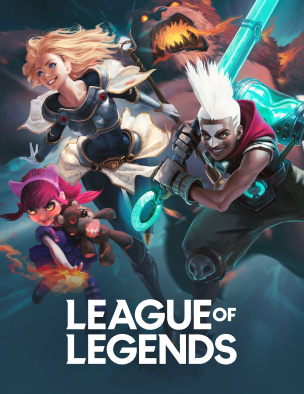

### Champion의 stats를 토대로 Clustering

리그오브레전드(LoL)의 각 챔피언들은 고유의 능력치들이 있다. 마법사는 주문력(AP)가 높아 스킬들의 데미지가 크다던가 저격수들은 원거리에서 공격을 하기에 공격력은 높지만 체력은 낮다. 따라서 각 챔피언들의 레벨 1 때의 기본 수치들을 살펴보면 챔피언이 어떤 역할군으로 활용될지 판단이 되는 경우가 있다. 하지만 이를 빗나가는 경우도 있는데 이는 성장에 따라, 챔피언의 고유 능력에 따라 레벨 1때는 약하지만 나중에는 강해지는 등 다양한 요소들이 있기 때문이다. 따라서 챔피언의 수치(Stats)로 챔피언들을 Clustering하는 것은 불가능하다.

하지만 이를 요약된 정보로는 가능해보였다. 예를 들어, 체력 / 회복속도 / 주문력 계수 등과 같이 지나치게 상세한 수치들은 Clustering에 도움이 안되지만, 단순히 공격, 방어, 마법 등과 같이 추상적으로 표현해놓은 수치들은 오히려 Clustering을 하기 더 용이했다. 또한 LoL은 게임의 다양성을 위하여 하나의 챔피언을 하나의 역할군(탑, 미드 etc)에 고정하지 않는데 이는 Clustering이 필요하게 하는 이유이면서 어렵게 하는 이유 중 하나이지만, 해당 챔피언의 보편적인 직업(마법사, 전사 etc)을 지정하는 데이터셋이 있기에 이를 사용하였다.

In [2]:
# Champion Stats Dataset
champs = pd.read_csv("champion_stats.csv", index_col=0)

champs['tags'] = champs['tags'].apply(lambda x: literal_eval(str(x)))

mlb = MultiLabelBinarizer()

champ_class = pd.DataFrame(mlb.fit_transform(champs['tags']),columns=mlb.classes_, index=champs.index)

champ_all = pd.concat([champs, champ_class], axis=1)
champ_all = champ_all.drop(['tags'], axis = 1)

챔피언의 Stats 정보를 통해 클러스터링 하기 위하여 다음과 같은 절차를 따랐다.

* 챔피언의 Tag에 대하여 MultiLabelBinarizer를 사용하여 표현하였다. 이를 통해 각 챔피언의 Tag가 두개 이상인 경우, One-Hot Encoding이 아니라 해당하는 모든 경우에 1을 입력해두었다. 
* ['attack', 'defense', 'magic', 'Assassin','Fighter','Mage','Marksman','Support','Tank']에 대하여 Clustering을 진행했으며, Clustering 자체가 Unsupervised이므로 군집에 대한 평가는 직접 진행했다. 
* 군집은 5개로 설정하였고, 

In [3]:
champs_selected = champ_all[['attack', 'defense', 'magic', 'Assassin','Fighter','Mage','Marksman','Support','Tank']]

km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0) 

y_km = km.fit_predict(champs_selected)

champs_copy = champ_all.copy()
champs_copy['key'] = y_km

In [4]:
champs_selected['key'] = y_km

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [5]:
from sklearn.decomposition import PCA
import plotly.express as px

X = champs_selected[['attack', 'defense', 'magic', 'Assassin','Fighter','Mage','Marksman','Support','Tank']]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=champs_selected['key'])
fig.show()

In [6]:
X = champs_selected[['attack', 'defense', 'magic', 'Assassin','Fighter','Mage','Marksman','Support','Tank']]

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=champs_selected['key'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

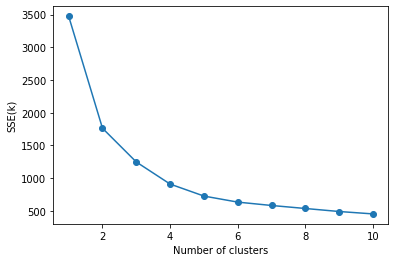

In [7]:
# Elbow method
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, n_init=10,
                max_iter=300, random_state=0)  # n_init=10: K-means++ with K=10을 의미
    km.fit(champs_selected)
    distortions.append(km.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE(k)')
plt.show()

In [8]:
champs_copy['key'] = ['category_'+str(i) for i in champs_copy['key'] ]

### Category

* category_0: 미드 포지션을 담당하는 챔피언들이 많다. Magic 수치가 높으며, 직업군으로 Mage / Support를 많이 담당하고 있다.
* category_1: 원거리 딜러 포지션을 담당하는 챔피언들이 많다. Attack 수치가 높으며 방어가 낮아 간혹 Khazix, MasterYi 같은 챔프도 존재한다.
* category_2: 탱커 포지션을 담당하는 챔피언들이 많다. 다른 카테고리는 다양한 직업군이 섞여 있는 경우가 있는데 이는 단일하다.
* category_3: 전사 포지션을 담당하는 챔피언들이 많다. 흔히 말하는 공격과 방어를 동시에 하는 '딜탱'들이 속한다.
* category_4: 암살자 포지션을 담당하는 챔피언들이 많다. 한번에 공격을 퍼붓는 '누커'나 속칭 '짤짤이'를 넣는 챔프들이 속한다.

In [9]:
champ_dict = {}
for index in range(len(champs_copy)):
    champ_name = champs_copy['id'][index]
    champ_name = champ_name.lower()
    champ_name = champ_name.replace("'", "")
    champ_name = champ_name.replace(" ", "")
    champ_type = champs_copy['key'][index]
    champ_dict[champ_name] = champ_type
    
champ_dict

{'aatrox': 'category_3',
 'ahri': 'category_0',
 'akali': 'category_4',
 'alistar': 'category_2',
 'amumu': 'category_0',
 'anivia': 'category_0',
 'annie': 'category_0',
 'aphelios': 'category_1',
 'ashe': 'category_1',
 'aurelionsol': 'category_0',
 'azir': 'category_4',
 'bard': 'category_4',
 'blitzcrank': 'category_2',
 'brand': 'category_0',
 'braum': 'category_2',
 'caitlyn': 'category_1',
 'camille': 'category_3',
 'cassiopeia': 'category_0',
 'chogath': 'category_2',
 'corki': 'category_4',
 'darius': 'category_3',
 'diana': 'category_4',
 'draven': 'category_1',
 'drmundo': 'category_2',
 'ekko': 'category_4',
 'elise': 'category_4',
 'evelynn': 'category_4',
 'ezreal': 'category_4',
 'fiddlesticks': 'category_0',
 'fiora': 'category_1',
 'fizz': 'category_4',
 'galio': 'category_2',
 'gangplank': 'category_3',
 'garen': 'category_3',
 'gnar': 'category_4',
 'gragas': 'category_2',
 'graves': 'category_3',
 'hecarim': 'category_3',
 'heimerdinger': 'category_0',
 'illaoi': 'c

In [10]:
unnecess_col = ['playoffs', 'playerid', 'gameid', 'datacompleteness', 'url', 'league', 'year', 'split', 
 'date', 'patch', 'position', 'player',
 'kills', 'deaths', 'assists', 'teamkills', 'teamdeaths', 'doublekills', 'triplekills', 'quadrakills', 'pentakills', 
 'firstbloodkill', 'ckpm',  'firstbloodassist', 'firstbloodvictim', 'golddiffat10', 'csdiffat10','xpdiffat10',
 'opp_dragons', 'elementaldrakes', 'opp_elementaldrakes', 'dragons (type unknown)', 'earned gpm', 'goldspent', 
 'team kpm', 'gspd', 'earnedgold', 'totalgold', 'goldat10', 'goldat15', 
 'opp_elders', 'opp_heralds', 'opp_barons', 'opp_towers','opp_inhibitors', 'damageshare', 'earnedgoldshare', 
 'total cs', 'opp_goldat10','opp_xpat10','opp_csat10', 'opp_goldat15', 'opp_xpat15', 'opp_csat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15']

### 2020년도 모든 대회 데이터들에 대하여 분석

전처리 절차
* league 데이터에 대하여, 불필요한 Column 삭제
*

In [11]:
league = pd.read_csv("2020_LOL.csv")
league = league[league.columns[~league.columns.isin(unnecess_col)]].reset_index(drop=True)

ban_list = ['champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5']
for ban in ban_list:
    league[ban] = league[ban].str.lower()
    league[ban] = league[ban].str.replace("'", "")
    league[ban] = league[ban].str.replace(" ", "")
    league[ban] = league[ban].str.replace(".", "")
    league[ban] = league[ban].str.replace("&willump", "")
    league[ban] = league[ban].str.replace("wukong", "monkeyking")
    
league['side'] = league['side'].astype('bool')
league['firstdragon'] = league['firstdragon'].astype('bool')
league['firstherald'] = league['firstherald'].astype('bool')
league['firstbaron'] = league['firstbaron'].astype('bool')
league['firsttower'] = league['firsttower'].astype('bool')
league['firstmidtower'] = league['firstmidtower'].astype('bool')
league['firsttothreetowers'] = league['firsttothreetowers'].astype('bool')

In [12]:
league

game  side            team     champion      ban1    ban2    ban3  \
0         1  True  SANDBOX Gaming       rumble   leblanc  irelia  reksai   
1         1  True  SANDBOX Gaming        elise   leblanc  irelia  reksai   
2         1  True  SANDBOX Gaming       qiyana   leblanc  irelia  reksai   
3         1  True  SANDBOX Gaming  missfortune   leblanc  irelia  reksai   
4         1  True  SANDBOX Gaming     nautilus   leblanc  irelia  reksai   
...     ...   ...             ...          ...       ...     ...     ...   
77539     4  True  Saigon Buffalo    seraphine  renekton  samira  graves   
77540     4  True  Saigon Buffalo        kaisa  renekton  samira  graves   
77541     4  True  Saigon Buffalo         sett  renekton  samira  graves   
77542     4  True        V Gaming          NaN   camille   akali    kayn   
77543     4  True  Saigon Buffalo          NaN  renekton  samira  graves   

           ban4      ban5  gamelength  ...    vspm  minionkills  monsterkills  \
0         yasuo  renekton        2220  ...  0.9459        276.0             9   
1         yasuo  renekton        2220  ...  2.7568         40.0           170   
2         yasuo  renekton        2220  ...  2.6757        312.0             8   
3         yasuo  renekton        2220  ...  1.7838        391.0            29   
4         yasuo  renekton        2220  ...  2.1081         30.0             0   
...         ...       ...         ...  ...     ...          ...           ...   
77539      ashe      jhin        2006  ...  0.8973        192.0             4   
77540      ashe      jhin        2006  ...  1.2263        269.0            39   
77541      ashe      jhin        2006  ...  3.2602         48.0             0   
77542  malphite      shen        2006  ...  7.9860        886.0           243   
77543      ashe      jhin        2006  ...  7.7767        818.0           200   

       monsterkillsownjungle  monsterkillsenemyjungle     cspm   xpat10  \
0                          5                        0   7.7027   4864.0   
1                        130                        0   5.6757   2887.0   
2                          2                        0   8.6486   4153.0   
3                         29                        0  11.3514   3233.0   
4                          0                        0   0.8108   2708.0   
...                      ...                      ...      ...      ...   
77539                      0                        0   5.8624   4604.0   
77540                     27                        8   9.2124   3141.0   
77541                      0                        0   1.4357   2447.0   
77542                    155                       37  33.7687  19294.0   
77543                    119                       25  30.4487  19027.0   

       csat10   xpat15  csat15  
0        88.0   7368.0   131.0  
1        57.0   4817.0    91.0  
2        80.0   6275.0   129.0  
3        93.0   4959.0   136.0  
4        12.0   3800.0    20.0  
...       ...      ...     ...  
77539    68.0   8142.0   113.0  
77540    86.0   5684.0   135.0  
77541    14.0   4156.0    24.0  
77542   343.0  29235.0   522.0  
77543   318.0  31616.0   488.0  

[77544 rows x 48 columns]

In [13]:
for start_index in range(0, len(league), 12):
    if (league['team'][start_index] != league['team'][start_index+1]) or (league['champion'][start_index] == league['champion'][start_index+1]): 
        continue
    else:
        try:
            team_1 = list(league.loc[start_index:start_index+4, 'champion'])
            team_2 = list(league.loc[start_index+5:start_index+9, 'champion'])

            team_1 = [champ_dict[key] for key in team_1]
            team_2 = [champ_dict[key] for key in team_2]

            league.at[start_index+10, 'champion'] = team_1
            league.at[start_index+11, 'champion'] = team_2
        except Exception as e:
            print(start_index)
            print(e)

In [14]:
league['side'] = labelencoder.fit_transform(league['side'])
league['result'] = labelencoder.fit_transform(league['result'])
league = league.dropna(axis='rows').reset_index(drop=True)

In [15]:
league

game  side            team  \
0        1     0  SANDBOX Gaming   
1        1     0              T1   
2        2     0              T1   
3        2     0  SANDBOX Gaming   
4        3     0              T1   
...    ...   ...             ...   
9222     2     0        V Gaming   
9223     3     0        V Gaming   
9224     3     0  Saigon Buffalo   
9225     4     0        V Gaming   
9226     4     0  Saigon Buffalo   

                                               champion      ban1      ban2  \
0     [category_0, category_4, category_0, category_...   leblanc    irelia   
1     [category_3, category_2, category_2, category_...    lucian     akali   
2     [category_1, category_3, category_0, category_...    syndra   leblanc   
3     [category_3, category_4, category_0, category_...    lucian     akali   
4     [category_3, category_3, category_2, category_...   leblanc    rumble   
...                                                 ...       ...       ...   
9222  [category_2, category_0, category_3, category_...    samira      kayn   
9223  [category_4, category_0, category_4, category_...      kayn   camille   
9224  [category_2, category_3, category_0, category_...    samira  renekton   
9225  [category_4, category_0, category_3, category_...   camille     akali   
9226  [category_2, category_3, category_0, category_...  renekton    samira   

         ban3         ban4       ban5  gamelength  ...     vspm  minionkills  \
0      reksai        yasuo   renekton        2220  ...  10.2703       1049.0   
1      leesin         olaf   jarvaniv        2220  ...   8.5946       1021.0   
2      rumble        braum      leona        2227  ...   6.8433       1011.0   
3      reksai       irelia    camille        2227  ...  10.6960        976.0   
4      leesin       gragas       olaf        1711  ...   9.1876        806.0   
...       ...          ...        ...         ...  ...      ...          ...   
9222  camille  missfortune       ashe        1664  ...   6.3822        708.0   
9223   lucian        galio  seraphine        2039  ...   8.0922        833.0   
9224   graves        leona       sett        2039  ...   8.1216        821.0   
9225     kayn     malphite       shen        2006  ...   7.9860        886.0   
9226   graves         ashe       jhin        2006  ...   7.7767        818.0   

      monsterkills  monsterkillsownjungle  monsterkillsenemyjungle     cspm  \
0              216                    166                        0  34.1892   
1              271                    193                        5  34.9189   
2              183                    151                        1  32.1688   
3              270                    126                       48  33.5698   
4              242                    126                       42  36.7504   
...            ...                    ...                      ...      ...   
9222           176                    128                       10  31.8750   
9223           260                    152                       46  32.1628   
9224           182                    106                       25  29.5145   
9225           243                    155                       37  33.7687   
9226           200                    119                       25  30.4487   

       xpat10  csat10   xpat15  csat15  
0     17845.0   330.0  27219.0   507.0  
1     17982.0   322.0  28884.0   519.0  
2     16947.0   300.0  26869.0   501.0  
3     19096.0   334.0  31702.0   557.0  
4     19034.0   365.0  30349.0   584.0  
...       ...     ...      ...     ...  
9222  17492.0   310.0  27111.0   479.0  
9223  18339.0   339.0  30661.0   525.0  
9224  18638.0   331.0  28686.0   512.0  
9225  19294.0   343.0  29235.0   522.0  
9226  19027.0   318.0  31616.0   488.0  

[9227 rows x 48 columns]

In [16]:
from collections import Counter

league['category_0'] = 0
league['category_1'] = 0
league['category_2'] = 0
league['category_3'] = 0
league['category_4'] = 0

for index, data in enumerate(league['champion']):
    data = Counter(data)
    keys = data.keys()
    for key in keys:
        league[key][index] = data[key]

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
ban1 = league['ban1']
ban2 = league['ban2']
ban3 = league['ban3']
ban4 = league['ban4']
ban5 = league['ban5']

ban1 = [champ_dict[i] for i in ban1]
ban2 = [champ_dict[i] for i in ban2]
ban3 = [champ_dict[i] for i in ban3]
ban4 = [champ_dict[i] for i in ban4]
ban5 = [champ_dict[i] for i in ban5]

In [18]:
ban_list = league[['ban1', 'ban2', 'ban3', 'ban4', 'ban5']].values

league['bans'] = [bans for bans in ban_list]

for index, bans in enumerate(league['bans']):
    league['bans'][index] = ['ban_'+champ_dict[i] for i in bans]

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
league['ban_category_0'] = 0
league['ban_category_1'] = 0
league['ban_category_2'] = 0
league['ban_category_3'] = 0
league['ban_category_4'] = 0

for index, data in enumerate(league['bans']):
    data = Counter(data)
    keys = data.keys()
    for key in keys:
        league[key][index] = data[key]

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
league = league.drop(['team', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'bans', 'champion'], axis=1) 

In [21]:
out_index = []
for index in range(0,len(league),2):
    rand = random.uniform(0,1)
    if rand > 0.5:
        out_index.append(index)
    else:
        out_index.append(index+1)
        
print(out_index)       

[0, 3, 4, 7, 9, 10, 12, 15, 17, 19, 21, 23, 24, 27, 29, 30, 33, 34, 36, 39, 40, 42, 44, 47, 48, 51, 52, 55, 56, 59, 61, 62, 64, 66, 68, 70, 73, 74, 77, 79, 81, 83, 84, 87, 88, 90, 92, 95, 96, 99, 101, 103, 104, 107, 108, 111, 112, 115, 116, 119, 121, 122, 124, 126, 129, 131, 132, 135, 136, 139, 141, 143, 144, 147, 149, 151, 153, 155, 157, 159, 160, 162, 164, 166, 169, 170, 172, 174, 177, 179, 180, 182, 184, 186, 189, 191, 193, 195, 196, 199, 201, 203, 204, 207, 209, 210, 212, 215, 216, 218, 221, 222, 225, 227, 228, 230, 233, 234, 236, 238, 240, 243, 245, 247, 249, 250, 253, 254, 256, 259, 261, 263, 264, 267, 268, 270, 272, 274, 277, 278, 280, 282, 285, 286, 289, 291, 292, 295, 296, 298, 301, 303, 304, 307, 308, 311, 312, 315, 317, 318, 321, 322, 325, 327, 328, 330, 333, 335, 336, 339, 341, 343, 345, 347, 349, 350, 353, 355, 356, 359, 361, 363, 364, 367, 369, 370, 373, 375, 377, 379, 380, 382, 384, 387, 388, 391, 393, 395, 396, 398, 401, 403, 405, 406, 409, 410, 412, 415, 417, 419, 420,

In [22]:
league  = league[league.index.isin(out_index)]

In [23]:
X = league.drop(['result'], axis = 1)
y = league['result']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1, stratify = y)

dtrain = xgb.DMatrix(x_train,label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [24]:
classifier = xgb.XGBClassifier()

fitted = classifier.fit(x_train, y_train)
pred = fitted.predict(x_test)

accuracy_score(pred, y_test)

0.9739978331527628

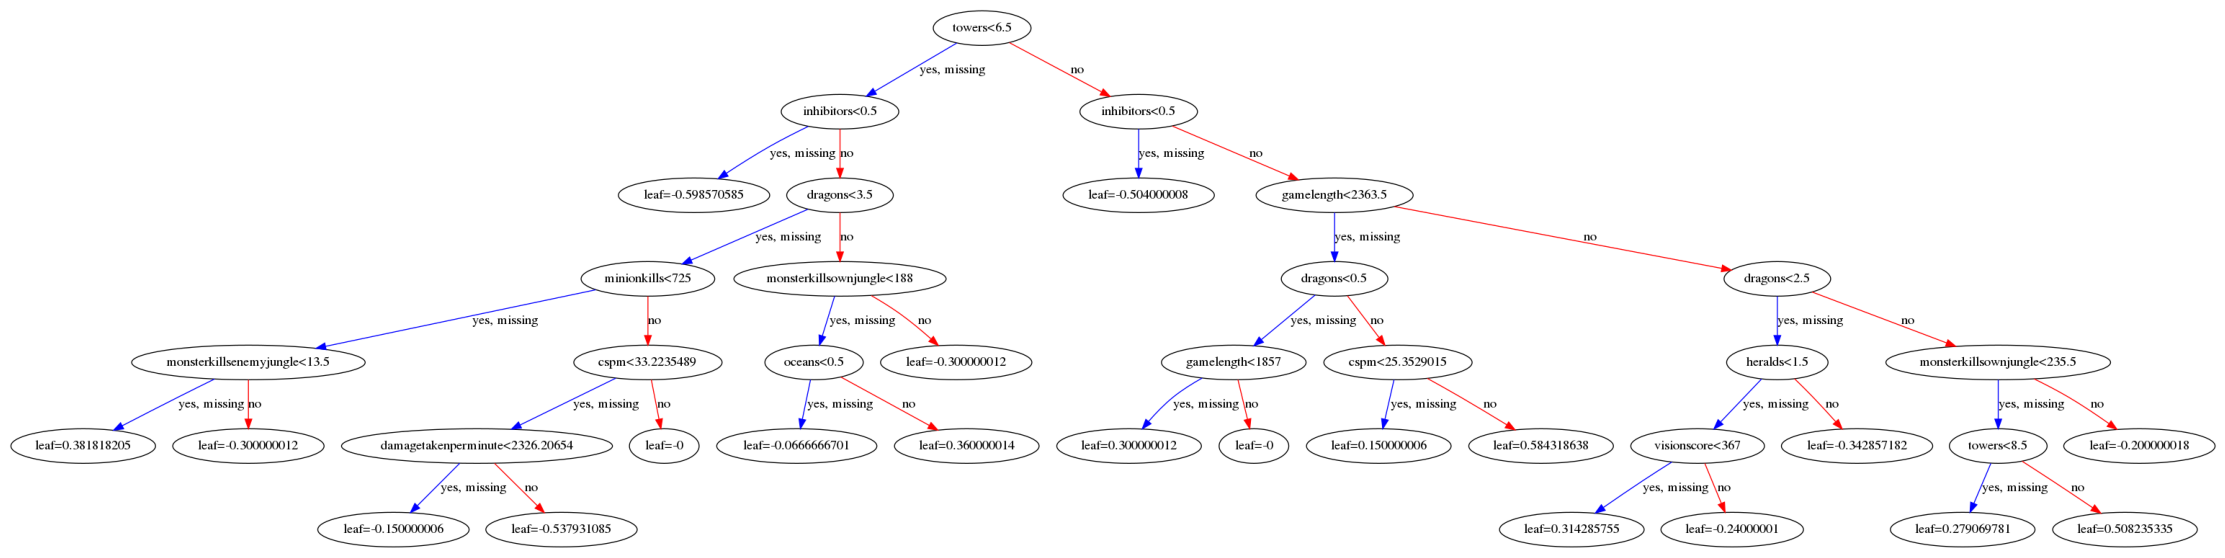

In [62]:
import matplotlib.pyplot as plt
xgb.plot_tree(fitted,num_trees=0)
plt.rcParams['figure.figsize']=[50,50]
plt.show()

In [25]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

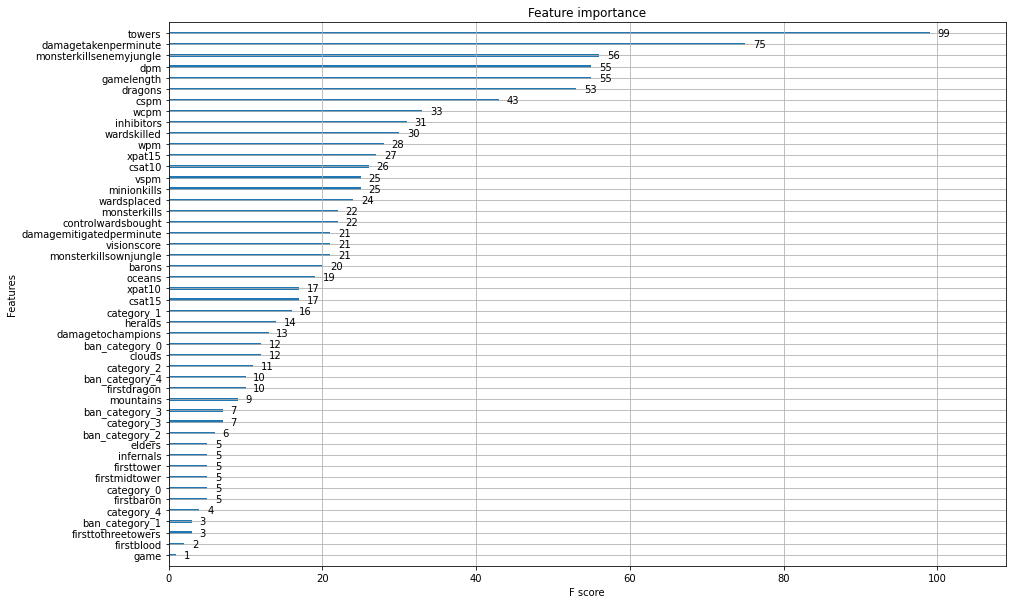

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))

xgb.plot_importance(fitted, ax = ax)

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(x_train, y_train)

GradientBoostingClassifier(random_state=0)

In [29]:
score_train = gbc.score(x_train, y_train) # train set 정확도

print('{:.3f}'.format(score_train))

score_test = gbc.score(x_test, y_test) # 일반화 정확도

print('{:.3f}'.format(score_test))

0.993
0.975


### LightGBM

In [41]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=200)

In [42]:
evals = [(x_test, y_test)]
lgbm.fit(x_train, y_train, early_stopping_rounds=100, eval_metric='auc',
         eval_set=evals, verbose=True)

[1]	valid_0's auc: 0.98926	valid_0's binary_logloss: 0.605773
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.990002	valid_0's binary_logloss: 0.534409
[3]	valid_0's auc: 0.98991	valid_0's binary_logloss: 0.474819
[4]	valid_0's auc: 0.991638	valid_0's binary_logloss: 0.42447
[5]	valid_0's auc: 0.991912	valid_0's binary_logloss: 0.38208
[6]	valid_0's auc: 0.993389	valid_0's binary_logloss: 0.345508
[7]	valid_0's auc: 0.993694	valid_0's binary_logloss: 0.313754
[8]	valid_0's auc: 0.993636	valid_0's binary_logloss: 0.285982
[9]	valid_0's auc: 0.993579	valid_0's binary_logloss: 0.26218
[10]	valid_0's auc: 0.993126	valid_0's binary_logloss: 0.241087
[11]	valid_0's auc: 0.994361	valid_0's binary_logloss: 0.223125
[12]	valid_0's auc: 0.994652	valid_0's binary_logloss: 0.206497
[13]	valid_0's auc: 0.994568	valid_0's binary_logloss: 0.192474
[14]	valid_0's auc: 0.994431	valid_0's binary_logloss: 0.179638
[15]	valid_0's auc: 0.99423	valid_0's binary_logloss: 0.

LGBMClassifier(n_estimators=200)

In [44]:
lgb_pred = lgbm.predict(x_test)

accuracy_score(lgb_pred, y_test)

0.9739978331527628

In [47]:
from catboost import CatBoostClassifier

In [52]:
model = CatBoostClassifier(iterations=50,
                           learning_rate=1,
                           depth=2)
# Fit model
model.fit(x_train, y_train)
# Get predicted classes
preds_class = model.predict(x_test)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(x_test)
# Get predicted RawFormulaVal
preds_raw = model.predict(x_test)

0:	learn: 0.1411087	total: 1.77ms	remaining: 86.6ms
1:	learn: 0.1038577	total: 3.83ms	remaining: 91.9ms
2:	learn: 0.0809872	total: 6.12ms	remaining: 95.9ms
3:	learn: 0.0791572	total: 9.12ms	remaining: 105ms
4:	learn: 0.0732651	total: 10.9ms	remaining: 98.3ms
5:	learn: 0.0665696	total: 12.8ms	remaining: 94.1ms
6:	learn: 0.0641515	total: 14.8ms	remaining: 91.1ms
7:	learn: 0.0586477	total: 16.9ms	remaining: 88.7ms
8:	learn: 0.0570528	total: 18.4ms	remaining: 84ms
9:	learn: 0.0554067	total: 19.8ms	remaining: 79.3ms
10:	learn: 0.0546146	total: 21.2ms	remaining: 75.3ms
11:	learn: 0.0533872	total: 22.9ms	remaining: 72.6ms
12:	learn: 0.0512858	total: 24.3ms	remaining: 69ms
13:	learn: 0.0506544	total: 25.7ms	remaining: 66ms
14:	learn: 0.0504360	total: 27.8ms	remaining: 65ms
15:	learn: 0.0479213	total: 31.1ms	remaining: 66ms
16:	learn: 0.0467520	total: 33.3ms	remaining: 64.6ms
17:	learn: 0.0452100	total: 35.4ms	remaining: 63ms
18:	learn: 0.0428762	total: 37.1ms	remaining: 60.5ms
19:	learn: 0.041

In [54]:
accuracy_score(preds_raw, y_test)

0.9739978331527628

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_cl=LogisticRegression()
rf_cl=RandomForestClassifier()
svm_cl=SVC()

voting_cl=VotingClassifier(estimators=[('lr', log_cl), ('rf', rf_cl), ('svc', svm_cl)],voting='hard')
voting_cl.fit(x_train, y_train)

from sklearn.metrics import accuracy_score
for cl in (log_cl, rf_cl, svm_cl, voting_cl):
    cl.fit(x_train, y_train)
    y_pred = cl.predict(x_test)
    print(cl.__class__.__name__, accuracy_score(y_test, y_pred))

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

LogisticRegression 0.8591549295774648
RandomForestClassifier 0.9739978331527628
SVC 0.7193932827735645


/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



VotingClassifier 0.8981581798483207


In [60]:
# out_of_bag (oob) 자료를 이용하여 test set의 accuracy 구함
# oob 자료는 oob_score = True로 지정.
bag_cl2 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, n_jobs=-1,bootstrap=True, oob_score=True)
bag_cl2.fit(x_train, y_train)
print(bag_cl2.oob_score_)

0.9742547425474255
